In [1]:
# Importing all the necassary libraries
import warnings
warnings.filterwarnings('ignore')

from math import sqrt
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import linear_model
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Exploratory Data Analysis

In [2]:
#Getting sense of the data
df = pd.read_csv("Data.csv")
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
# Checking for missing values and categorical variables in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [4]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


__Maximum value for y and z are unusually high, which might also indicate an error or outlier.__

In [5]:
df.describe(include='O')

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


In [6]:
#There are unecessary columns which needs to be dropped
df = df.drop(columns = ["Unnamed: 0"],axis=1)

### Outlier detection

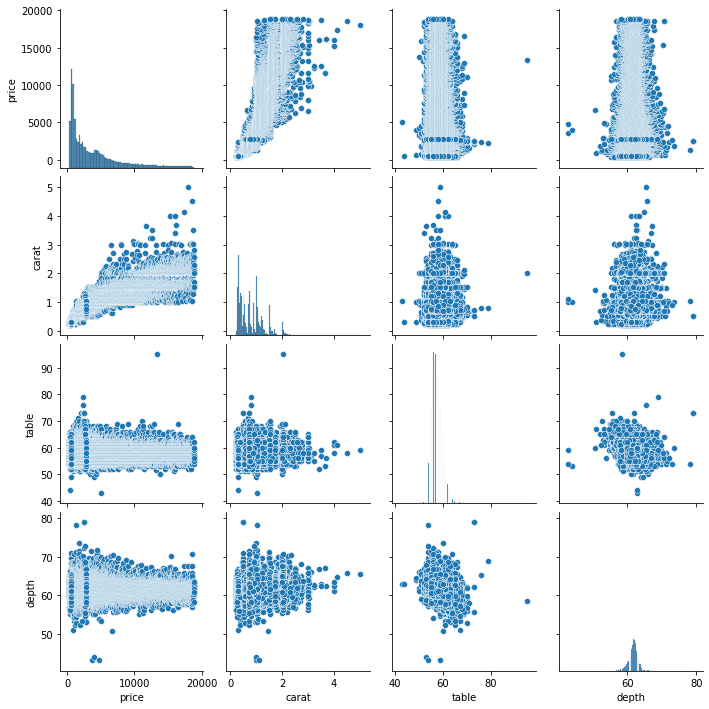

In [7]:
sns.pairplot(df[['price','carat','table','depth']])

__Insights:__

- __There are some features with datapoint that are far from the rest of the dataset which will affect the outcome of our regression model.__
- __Depth and table should be capped before that we will examine the regression line for being sure.__

In [8]:
#Dropping the outliers. 
df = df[(df["depth"]<75)&(df["depth"]>45)]
df = df[(df["table"]<80)&(df["table"]>40)]
df.shape

(53933, 10)

__7 records are dropped which were outliers__

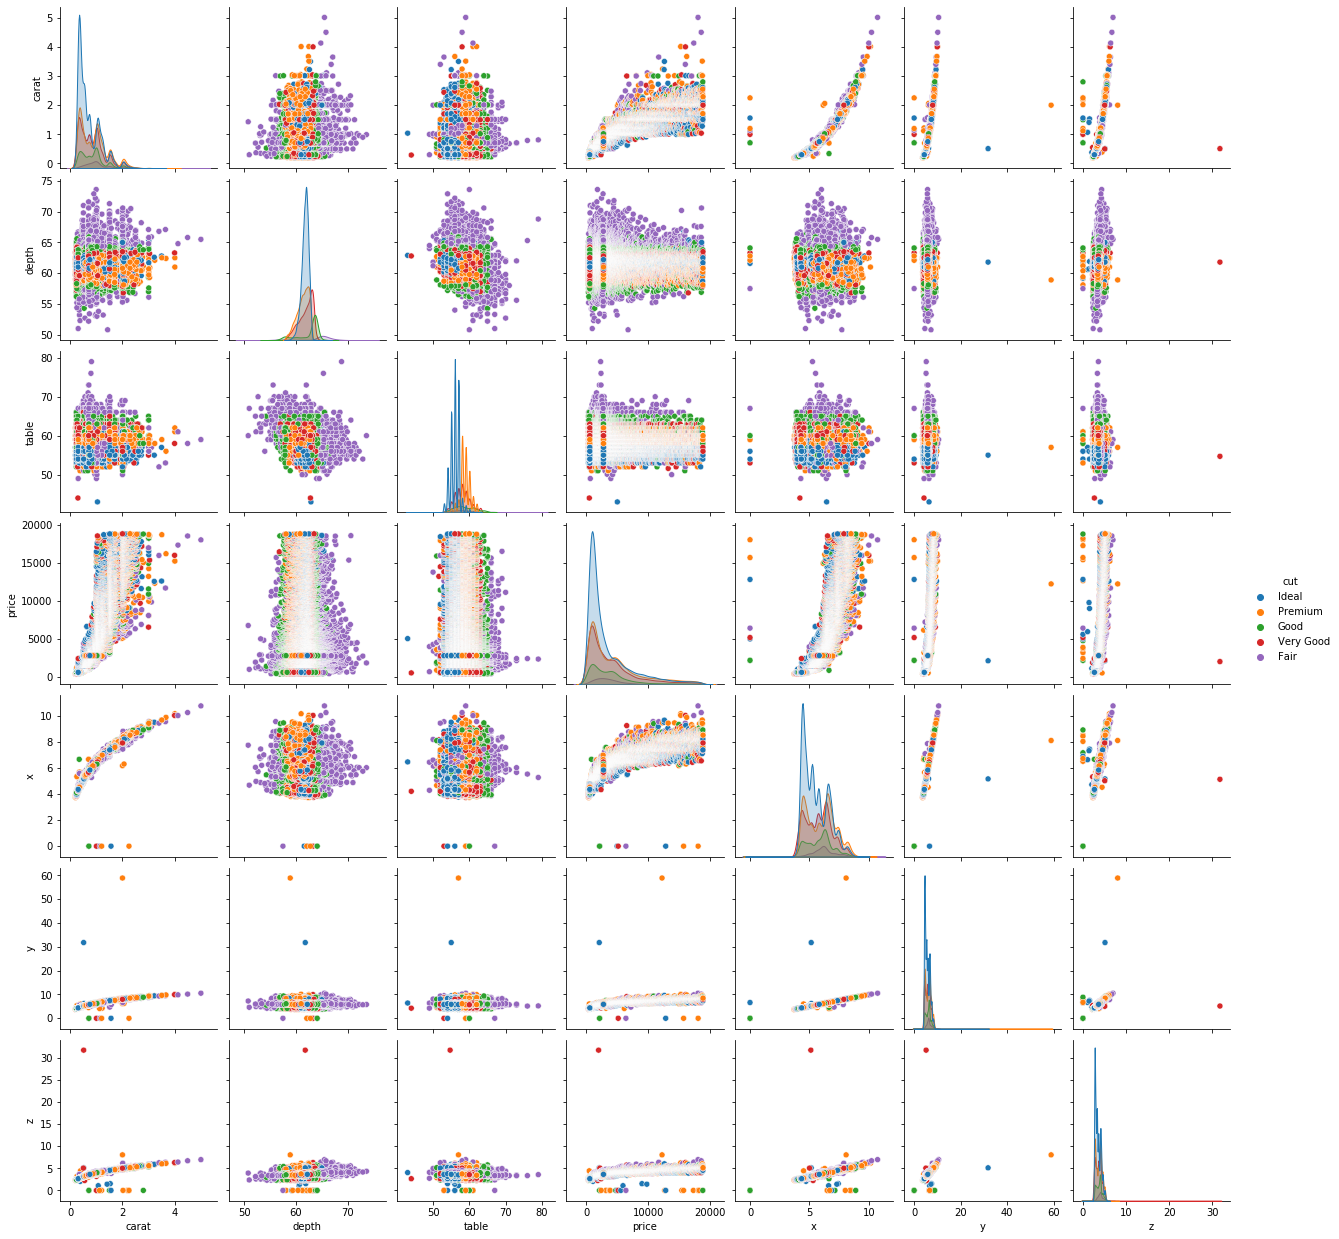

In [9]:
sns.pairplot(df, hue = 'cut')

In [10]:
df.describe()

,carat,depth,table,price,x,y,z
count,53933.000000,53933.000000,53933.000000,53933.000000,53933.000000,53933.000000,53933.000000
mean,0.797911,61.749543,57.456094,3932.712180,5.731092,5.734467,3.538643
std,0.474005,1.420407,2.226577,3989.463941,1.121763,1.142140,0.705692
min,0.200000,50.800000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5325.000000,6.540000,6.540000,4.040000
max,5.010000,73.600000,79.000000,18823.000000,10.740000,58.900000,31.800000


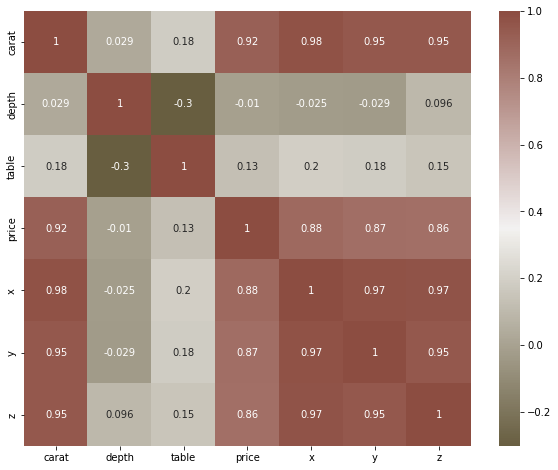

In [11]:
#correlation matrix
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= df.corr()
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

- __High correlation between price and carat. Also high correlation between price and length(x), price and width(y), price and depth(z).__
- __High correlation between carat and length(x), carat and width(y), carat and depth(z).__
- __Length(x) is almost fully correlated with depth(z) and height(y).__

In [12]:
#dropping fully correlated variables
df = df.drop(columns = ["x", "y", "z"],axis=1)

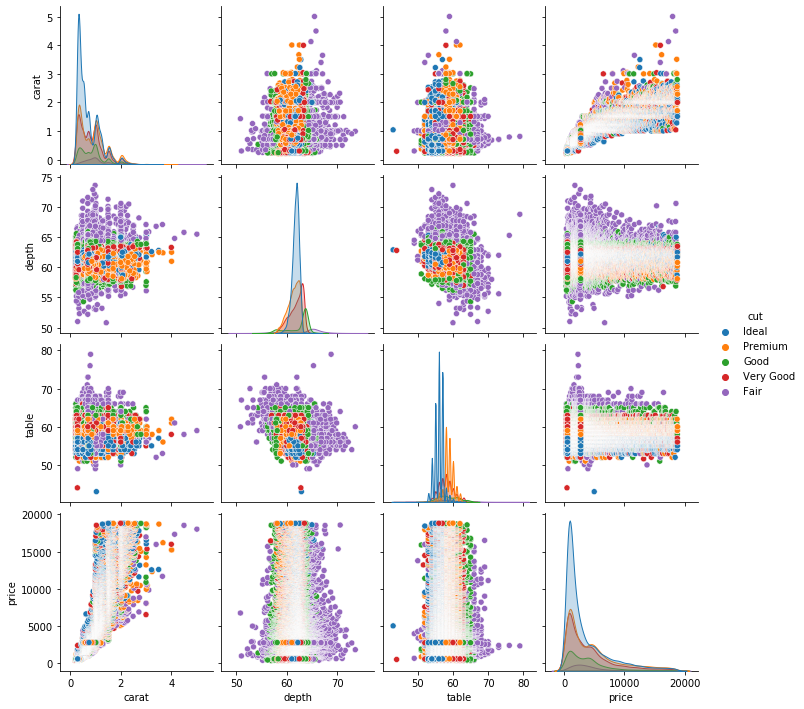

In [13]:
sns.pairplot(df, hue = 'cut')

### Bi-variate Analysis

In [ ]:
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
color_order = ["J", "I", "H", "G", "F", "E", "D"]
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

fig, axs = plt.subplots(3,1,figsize=(20,15))
fig.suptitle('Discrete Features Correlation with price',fontsize=20)
plt.subplot(3,1,1)
plt.title('CUT')
sns.violinplot(x="cut", y="price", data=df, order = cut_order)
plt.subplot(3,1,2)
plt.title('COLOUR')
sns.violinplot(x="color", y="price", data=df, order = color_order)
plt.subplot(3,1,3)
plt.title('CLARITY')
sns.violinplot(x="clarity", y="price", data=df, order = clarity_order);



Cut insights:

- Most of the diamonds with Ideal Cut costs in between 326 to 2500
- Most of the diamonds with Premium Cut costs in between 326 to 5000
- Most of the diamonds with Very Good Cut costs in between 336 to 4800
- Most of the diamonds with Good Cut costs in between 327 to 4700
- Most of the diamonds with Fair Cut costs in between 337 to 5000

Color insights:

- Most of the diamonds with G Color costs in between 354 to 2500
- Most of the diamonds with E Color costs in between 326 to 3700
- Most of the diamonds with F Color costs in between 342 to 4500
- Most of the diamonds with H Color costs in between 337 to 5200
- Most of the diamonds with D Color costs in between 357 to 2500
- Most of the diamonds with I Color costs in between 334 to 6200
- Most of the diamonds with J Color costs in between 335 to 6400

Clarity insights:

- Most of the diamonds with SI1 Clarity costs in between 326 to 5100
- Most of the diamonds with VS2 Clarity costs in between 334 to 2600
- Most of the diamonds with SI2 Clarity costs in between 326 to 5200
- Most of the diamonds with VS1 Clarity costs in between 327 to 3600
- Most of the diamonds with VVS2 Clarity costs in between 336 to 3500
- Most of the diamonds with VVS1 Clarity costs in between 336 to 3000
- Most of the diamonds with IF Clarity costs in between 369 to 2500
- Most of the diamonds with I1 Clarity costs in between 345 to 7500

### Univariate Analysis

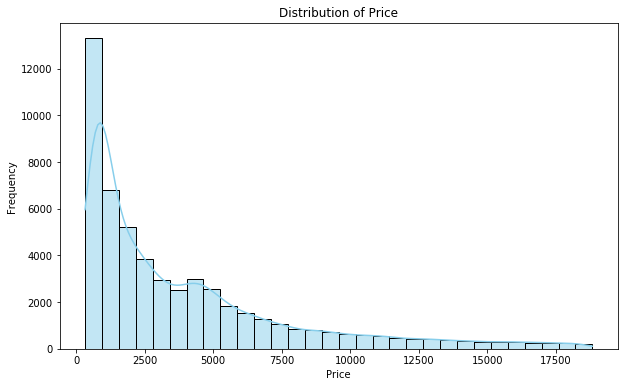

In [15]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the distribution of price
sns.histplot(data=df, x='price', bins=30, kde=True, color='skyblue')

# Add labels and title
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Show plot
plt.show();


__Insights:__

- __We can see the price distribution is right skewed. Most of the prices fall below 2500.__
- __Also there is a lot of high and medium prices which belongs to the rearest and nearly rear diamonds.__

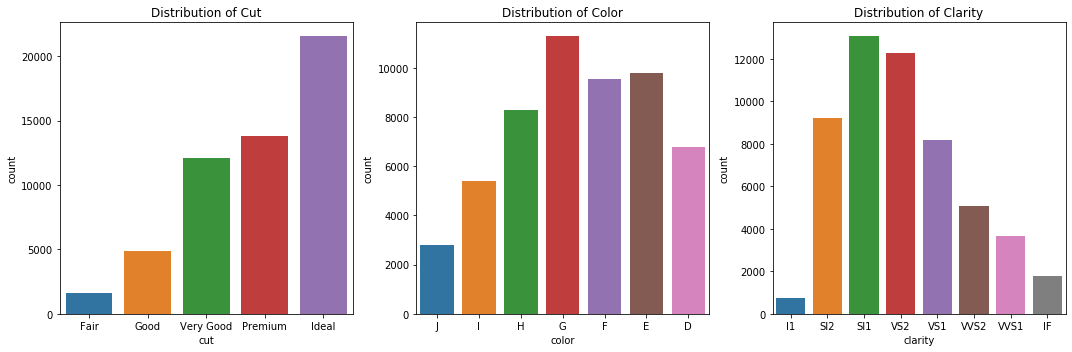

In [16]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot distribution of cut
sns.countplot(x='cut', data=df, ax=axes[0], order=["Fair", "Good", "Very Good", "Premium", "Ideal"])
axes[0].set_title('Distribution of Cut')

# Plot distribution of color
sns.countplot(x='color', data=df, ax=axes[1], order=["J", "I", "H", "G", "F", "E", "D"])
axes[1].set_title('Distribution of Color')

# Plot distribution of clarity
sns.countplot(x='clarity', data=df, ax=axes[2], order=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"])
axes[2].set_title('Distribution of Clarity')

plt.tight_layout()
plt.show();


__Cut insights:__

- __Most of the diamonds have Ideal Cut with a ratio of 39.95% followed by Premium Cut and Very Good Cut__
- __Only few have Fair Cut with a ratio of 2.98%.__

__Color insights:__

- __Most of the diamonds have G color with a ratio of 20.93% followed by E and F__
- __Only few have J color with a ratio of 5.21%.__

__Clarity insights:__

- __Most of the diamonds have SI1 clarity with a ratio of 24.22% followed by VS2 and SI2__
- __Only few have I1 clarity with a ratio of 1.37%.__

## converting clarity into ordered variabble 

In [17]:
# Encoding the categorical variables
df['cut'] = df['cut'].map({'Ideal': 4, 'Premium': 3, 'Very Good': 2, 'Good': 1, 'Fair': 0})
df['color'] = df['color'].map({'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0})
df['clarity'] = df['clarity'].map({'IF': 7, 'VVS1': 6, 'VVS2': 5, 'VS1': 4, 'VS2': 3, 'SI1': 2, 'SI2': 1, 'I1': 0})


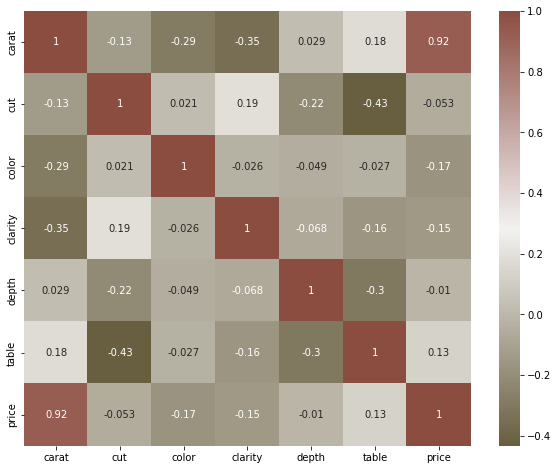

In [18]:
#correlation matrix
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= df.corr()
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

# Data splitting

In [19]:
X = df.drop(["price"],axis=1)
y = df.price

In [20]:
# Split the original data into train-validate set (70%) and test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Display the shapes of the resulting sets
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (37753, 6)
Test set shape: (16180, 6)


## Model 1: Decision Tree 

In [21]:
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train,y_train)

#Train set performance
print(f"Train R Squared Value: {r2_score(y_train,dt.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,dt.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,dt.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {r2_score(y_test,dt.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,dt.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,dt.predict(X_test)):.2f}")

#Parameter tuning

# Define the hyperparameters to tune
#param_grid = {'max_depth':range(1, 25)}
param_grid = {'max_depth': range(1, 25)}

# Use GridSearchCV to tune the hyperparameters
grid_search_dt = GridSearchCV(dt, param_grid=param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_dt.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

print('--------------------------------')
print("Best parameters: ", best_params_dt)
print(f"Best R Squared score: {best_score_dt*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_dt = grid_search_dt.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_dt.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_dt.predict(X_test))*100:.2f}%");

Train R Squared Value: 99.98%
Train Mean Absolute Error: 15.98
Train Mean Squared Error: 2495.08
--------------------------------
Test R Squared Value: 96.76%
Test Mean Absolute Error: 356.86
Test Mean Squared Error: 520736.14
--------------------------------
Best parameters:  {'max_depth': 11}
Best R Squared score: 97.54%
--------------------------------
Train R Squared Value with best parameters: 98.52%
Test R Squared Value with best parameters: 97.63%


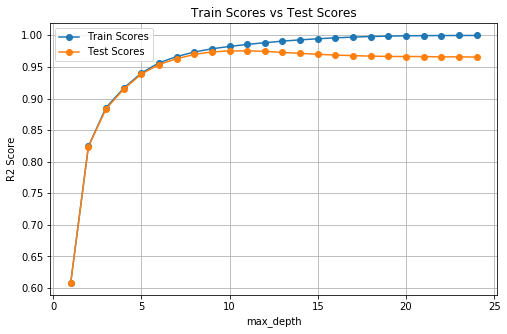

In [22]:
# Visualizing best parameter
#Get the train and test scores from cv_results_
train_scores = grid_search_dt.cv_results_['mean_train_score']
test_scores = grid_search_dt.cv_results_['mean_test_score']
param_depth = grid_search_dt.cv_results_['param_max_depth']

# Plot the train and test scores against the hyperparameter values
plt.figure(figsize=(8, 5))
plt.plot(param_depth, train_scores, label='Train Scores', marker='o')
plt.plot(param_depth, test_scores, label='Test Scores', marker='o')
plt.legend()
plt.ylabel("R2 Score")
plt.xlabel("max_depth")
plt.title('Train Scores vs Test Scores')
plt.grid(True)
plt.show();

## Model 2: Random Forest

In [23]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)

#Train set performance
print(f"Train R Squared Value: {r2_score(y_train,rf.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,rf.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,rf.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {r2_score(y_test,rf.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,rf.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,rf.predict(X_test)):.2f}")

#Parameter tuning

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth':range(1, 25)
}

# Use GridSearchCV to tune the hyperparameters
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print('--------------------------------')
print("Best parameters: ", best_params_rf)
print(f"Best R Squared score: {best_score_rf*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_rf = grid_search_rf.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_rf.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_rf.predict(X_test))*100:.2f}%");

Train R Squared Value: 99.72%
Train Mean Absolute Error: 111.52
Train Mean Squared Error: 44535.64
--------------------------------
Test R Squared Value: 98.10%
Test Mean Absolute Error: 284.56
Test Mean Squared Error: 304847.09
--------------------------------
Best parameters:  {'max_depth': 13, 'n_estimators': 150}
Best R Squared score: 98.08%
--------------------------------
Train R Squared Value with best parameters: 99.12%
Test R Squared Value with best parameters: 98.17%


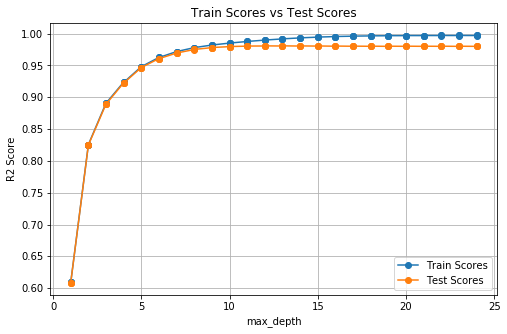

In [24]:
# Get the train and test scores from cv_results_
train_scores = grid_search_rf.cv_results_['mean_train_score']
test_scores = grid_search_rf.cv_results_['mean_test_score']
param_depth = grid_search_rf.cv_results_['param_max_depth']

# Plot the train and test scores against the hyperparameter values- max_depth
plt.figure(figsize=(8, 5))
plt.plot(param_depth, train_scores, label='Train Scores', marker='o')
plt.plot(param_depth, test_scores, label='Test Scores', marker='o')
plt.legend()
plt.ylabel("R2 Score")
plt.xlabel("max_depth")
plt.title('Train Scores vs Test Scores')
plt.grid(True)
plt.show();

## Model 3: Linear SVM

In [25]:
svm= SVR()
svm.fit(X_train, y_train)

#Train set performance
print(f"Train R Squared Value: {-r2_score(y_train,svm.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,svm.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,svm.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {-r2_score(y_test,svm.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,svm.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,svm.predict(X_test)):.2f}")

#Parameter tuning

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

# Use GridSearchCV to tune the hyperparameters
grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_svm.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_svm = grid_search_svm.best_params_
best_score_svm = -grid_search_svm.best_score_ # Negative because GridSearchCV uses negative MSE for optimization

print('--------------------------------')
print("Best parameters: ", best_params_svm)
print(f"Best R Squared score: {-best_score_svm*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_svm = grid_search_svm.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_svm.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_svm.predict(X_test))*100:.2f}%");

Train R Squared Value: 14.36%
Train Mean Absolute Error: 2793.59
Train Mean Squared Error: 18131751.06
--------------------------------
Test R Squared Value: 14.94%
Test Mean Absolute Error: 2810.70
Test Mean Squared Error: 18456154.22
--------------------------------
Best parameters:  {'C': 100, 'gamma': 0.1}
Best R Squared score: 84.37%
--------------------------------
Train R Squared Value with best parameters: 86.43%
Test R Squared Value with best parameters: 86.23%


## Model 4: Gradient boosting

In [26]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

#Train set performance
print(f"Train R Squared Value: {r2_score(y_train,gb.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,gb.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,gb.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {r2_score(y_test,gb.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,gb.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,gb.predict(X_test)):.2f}")

#Parameter tuning for Random Forest

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Use GridSearchCV to tune the hyperparameters
grid_search_gb = GridSearchCV(gb, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_gb.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_ 

print('--------------------------------')
print("Best parameters: ", best_params_gb)
print(f"Best R Squared score: {best_score_gb*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_gb = grid_search_gb.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_gb.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_gb.predict(X_test))*100:.2f}%");

Train R Squared Value: 97.70%
Train Mean Absolute Error: 335.32
Train Mean Squared Error: 364693.38
--------------------------------
Test R Squared Value: 97.65%
Test Mean Absolute Error: 341.68
Test Mean Squared Error: 377274.53
--------------------------------
Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Best R Squared score: 98.17%
--------------------------------
Train R Squared Value with best parameters: 98.58%
Test R Squared Value with best parameters: 98.27%


## Model 5: K-Neighbours

In [27]:
knn = KNeighborsRegressor()

knn.fit(X_train, y_train)

#Train set performance
print(f"Train R Squared Value: {r2_score(y_train,knn.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,knn.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,knn.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {r2_score(y_test,knn.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,knn.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,knn.predict(X_test)):.2f}")

#Parameter tuning for Random Forest

# Define the hyperparameters to tune
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Use GridSearchCV to tune the hyperparameters
grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_knn.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_ 

print('--------------------------------')
print("Best parameters: ", best_params_knn)
print(f"Best R Squared score: {best_score_knn*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_knn = grid_search_knn.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_knn.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_knn.predict(X_test))*100:.2f}%");

Train R Squared Value: 86.48%
Train Mean Absolute Error: 834.78
Train Mean Squared Error: 2143835.51
--------------------------------
Test R Squared Value: 79.10%
Test Mean Absolute Error: 1057.72
Test Mean Squared Error: 3356341.83
--------------------------------
Best parameters:  {'n_neighbors': 3, 'p': 1}
Best R Squared score: 78.03%
--------------------------------
Train R Squared Value with best parameters: 90.96%
Test R Squared Value with best parameters: 80.64%


## Model 6: XGBoost

In [28]:
xgb = XGBRegressor(random_state=0)
xgb.fit(X_train, y_train)

#Train set performance
print(f"Train R Squared Value: {r2_score(y_train,xgb.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,xgb.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,xgb.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {r2_score(y_test,xgb.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,xgb.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,xgb.predict(X_test)):.2f}")

#Parameter tuning for Random Forest

# Define the hyperparameters to tune
param_grid = {
    'learning_rate': np.logspace(-2, 0, 3),
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Use GridSearchCV to tune the hyperparameters
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_xgb.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_ 

print('--------------------------------')
print("Best parameters: ", best_params_xgb)
print(f"Best R Squared score: {best_score_xgb*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_xgb = grid_search_xgb.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_xgb.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_xgb.predict(X_test))*100:.2f}%");

Train R Squared Value: 98.96%
Train Mean Absolute Error: 228.13
Train Mean Squared Error: 165022.62
--------------------------------
Test R Squared Value: 98.24%
Test Mean Absolute Error: 277.91
Test Mean Squared Error: 283053.40
--------------------------------
Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Best R Squared score: 98.21%
--------------------------------
Train R Squared Value with best parameters: 98.83%
Test R Squared Value with best parameters: 98.31%


## Model 7 : Lightgbm

In [29]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(X_train, y_train)

#Train set performance
print(f"Train R Squared Value: {r2_score(y_train,lgbm.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,lgbm.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,lgbm.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {r2_score(y_test,lgbm.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,lgbm.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,lgbm.predict(X_test)):.2f}")

#Parameter tuning for Random Forest

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 10,100],
    'max_depth': [6, 8, 10, 12],
    'num_leaves': [31, 63, 127] 
}

# Use GridSearchCV to tune the hyperparameters
grid_search_lgbm = GridSearchCV(lgbm, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_lgbm.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_lgbm = grid_search_lgbm.best_params_
best_score_lgbm = grid_search_lgbm.best_score_ 

print('--------------------------------')
print("Best parameters: ", best_params_lgbm)
print(f"Best R Squared score: {best_score_lgbm*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_lgbm = grid_search_lgbm.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_lgbm.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_lgbm.predict(X_test))*100:.2f}%");

Train R Squared Value: 98.53%
Train Mean Absolute Error: 261.97
Train Mean Squared Error: 233075.46
--------------------------------
Test R Squared Value: 98.27%
Test Mean Absolute Error: 279.97
Test Mean Squared Error: 277458.96
--------------------------------
Best parameters:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150, 'num_leaves': 63}
Best R Squared score: 98.19%
--------------------------------
Train R Squared Value with best parameters: 98.58%
Test R Squared Value with best parameters: 98.27%


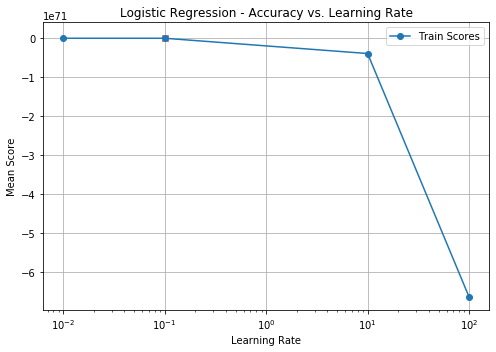

In [33]:
param_grid = {
    'learning_rate': [0.01, 0.1, 10,100]
}

# Use GridSearchCV to tune the hyperparameters
grid_search_lgbm_1 = GridSearchCV(lgbm, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_lgbm_1.fit(X_train, y_train)

# Get the train and test scores from cv_results_
train_scores = grid_search_lgbm_1.cv_results_['mean_train_score']
test_scores = grid_search_lgbm_1.cv_results_['mean_test_score']
param_learning = grid_search_lgbm_1.cv_results_['param_learning_rate']

# Plot the performance as a function of parameters
plt.figure(figsize=(8, 18))

# Logistic Regression
plt.subplot(3, 1, 1)
plt.plot(param_learning, train_scores, label='Train Scores', marker='o')
#plt.plot(param_learning, test_scores, label='Test Scores', marker='o')
plt.scatter([grid_search_lgbm_1.best_params_['learning_rate']], [grid_search_lgbm_1.best_score_], color='red', marker='x')
plt.title('Logistic Regression - Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Score')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show();


## Model 8: Catboost

In [34]:
cat = CatBoostRegressor(verbose=0)
cat.fit(X_train, y_train)

#Train set performance
print(f"Train R Squared Value: {r2_score(y_train,cat.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,cat.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,cat.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {r2_score(y_test,cat.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,cat.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,cat.predict(X_test)):.2f}")

#Parameter tuning for Random Forest

# Define the hyperparameters to tune
param_grid = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7]
}


# Use GridSearchCV to tune the hyperparameters
grid_search_cat = GridSearchCV(cat, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_cat.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_cat = grid_search_cat.best_params_
best_score_cat = grid_search_cat.best_score_ 

print('--------------------------------')
print("Best parameters: ", best_params_cat)
print(f"Best R Squared score: {best_score_cat*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_cat = grid_search_cat.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_cat.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_cat.predict(X_test))*100:.2f}%");

Train R Squared Value: 98.67%
Train Mean Absolute Error: 250.63
Train Mean Squared Error: 210128.91
--------------------------------
Test R Squared Value: 98.33%
Test Mean Absolute Error: 274.52
Test Mean Squared Error: 268392.77
--------------------------------
Best parameters:  {'depth': 7, 'iterations': 150, 'learning_rate': 0.2}
Best R Squared score: 98.17%
--------------------------------
Train R Squared Value with best parameters: 98.51%
Test R Squared Value with best parameters: 98.25%


## Model 9: Linear Regression

In [35]:
lin = make_pipeline(PolynomialFeatures(), LinearRegression())
lin.fit(X_train, y_train)

#Train set performance
print(f"Train R Squared Value: {r2_score(y_train,lin.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,lin.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,lin.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {r2_score(y_test,lin.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,lin.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,lin.predict(X_test)):.2f}")

#Parameter tuning for Random Forest

# Define the hyperparameters to tune
param_grid = {
    'polynomialfeatures__degree': range(1, 10)
}


# Use GridSearchCV to tune the hyperparameters
grid_search_lin = GridSearchCV(lin, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_lin.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_lin = grid_search_lin.best_params_
best_score_lin = grid_search_lin.best_score_ 

print('--------------------------------')
print("Best parameters: ", best_params_lin)
print(f"Best R Squared score: {best_score_lin*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_lin = grid_search_lin.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_lin.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_lin.predict(X_test))*100:.2f}%");

Train R Squared Value: 94.97%
Train Mean Absolute Error: 552.36
Train Mean Squared Error: 796958.67
--------------------------------
Test R Squared Value: 94.83%
Test Mean Absolute Error: 555.93
Test Mean Squared Error: 830285.93
--------------------------------
Best parameters:  {'polynomialfeatures__degree': 4}
Best R Squared score: 97.54%
--------------------------------
Train R Squared Value with best parameters: 97.67%
Test R Squared Value with best parameters: 97.51%


In [36]:
lasso = make_pipeline(PolynomialFeatures(), Lasso())
lasso.fit(X_train, y_train)

#Train set performance
print(f"Train R Squared Value: {r2_score(y_train,lasso.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,lasso.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,lasso.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {r2_score(y_test,lasso.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,lasso.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,lasso.predict(X_test)):.2f}")

#Parameter tuning for Random Forest

# Define the hyperparameters to tune
param_grid = {
    'polynomialfeatures__degree': range(1, 10)
}


# Use GridSearchCV to tune the hyperparameters
grid_search_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_lasso.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_lasso = grid_search_lasso.best_params_
best_score_lasso = grid_search_lasso.best_score_ 

print('--------------------------------')
print("Best parameters: ", best_params_lasso)
print(f"Best R Squared score: {best_score_lasso*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_lasso = grid_search_lasso.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_lasso.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_lasso.predict(X_test))*100:.2f}%");

Train R Squared Value: 94.95%
Train Mean Absolute Error: 552.88
Train Mean Squared Error: 801084.00
--------------------------------
Test R Squared Value: 94.82%
Test Mean Absolute Error: 555.80
Test Mean Squared Error: 831200.25
--------------------------------
Best parameters:  {'polynomialfeatures__degree': 5}
Best R Squared score: 97.63%
--------------------------------
Train R Squared Value with best parameters: 97.69%
Test R Squared Value with best parameters: 97.62%


In [37]:
ridge = make_pipeline(PolynomialFeatures(), Ridge())
ridge.fit(X_train, y_train)

#Train set performance
print(f"Train R Squared Value: {r2_score(y_train,ridge.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,ridge.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,ridge.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {r2_score(y_test,ridge.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,ridge.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,ridge.predict(X_test)):.2f}")

#Parameter tuning for Random Forest

# Define the hyperparameters to tune
param_grid = {
    'polynomialfeatures__degree': range(1, 10)
}


# Use GridSearchCV to tune the hyperparameters
grid_search_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_ridge.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_ 

print('--------------------------------')
print("Best parameters: ", best_params_ridge)
print(f"Best R Squared score: {best_score_ridge*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_ridge = grid_search_ridge.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_ridge.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_ridge.predict(X_test))*100:.2f}%");

Train R Squared Value: 94.97%
Train Mean Absolute Error: 552.51
Train Mean Squared Error: 797776.47
--------------------------------
Test R Squared Value: 94.83%
Test Mean Absolute Error: 555.93
Test Mean Squared Error: 829766.26
--------------------------------
Best parameters:  {'polynomialfeatures__degree': 4}
Best R Squared score: 97.54%
--------------------------------
Train R Squared Value with best parameters: 97.65%
Test R Squared Value with best parameters: 97.50%


## Model 10: MLP

In [38]:
mlp = MLPRegressor(max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

#Train set performance
print(f"Train R Squared Value: {r2_score(y_train,mlp.predict(X_train))*100:.2f}%")
print(f"Train Mean Absolute Error: {mean_absolute_error(y_train,mlp.predict(X_train)):.2f}")
print(f"Train Mean Squared Error: {mean_squared_error(y_train,mlp.predict(X_train)):.2f}")

#Test set performance
print('--------------------------------')
print(f"Test R Squared Value: {r2_score(y_test,mlp.predict(X_test))*100:.2f}%")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test,mlp.predict(X_test)):.2f}")
print(f"Test Mean Squared Error: {mean_squared_error(y_test,mlp.predict(X_test)):.2f}")

#Parameter tuning for Random Forest

# Define the hyperparameters to tune
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'max_iter': [200, 300, 500],
    'alpha': [0.0001, 0.001, 0.01],
}


# Use GridSearchCV to tune the hyperparameters
grid_search_mlp = GridSearchCV(mlp, param_grid, cv=5, scoring='r2',return_train_score=True)
grid_search_mlp.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params_mlp = grid_search_mlp.best_params_
best_score_mlp = grid_search_mlp.best_score_ 

print('--------------------------------')
print("Best parameters: ", best_params_mlp)
print(f"Best R Squared score: {best_score_mlp*100:.2f}%")

#print(grid_search.cv_results_.keys())
best_mlp = grid_search_mlp.best_estimator_

# Calculate the r2 for the training set
print('--------------------------------')
print(f"Train R Squared Value with best parameters: {r2_score(y_train, best_mlp.predict(X_train))*100:.2f}%")

# Calculate the r2 for the Test set
print(f"Test R Squared Value with best parameters: {r2_score(y_test, best_mlp.predict(X_test))*100:.2f}%");

Train R Squared Value: 94.89%
Train Mean Absolute Error: 578.72
Train Mean Squared Error: 809650.39
--------------------------------
Test R Squared Value: 94.91%
Test Mean Absolute Error: 582.63
Test Mean Squared Error: 817207.83
--------------------------------
Best parameters:  {'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'max_iter': 500}
Best R Squared score: 97.28%
--------------------------------
Train R Squared Value with best parameters: 97.60%
Test R Squared Value with best parameters: 97.63%


## Model Evaluation

In [39]:
#creating function to calculate mae, mse and r2 scores
def performance(y_true, y_pred):
    mae_score = round(mean_absolute_error(y_true,y_pred),0)
    mse_score = round(mean_squared_error(y_true,y_pred),0)
    R2_score= round(r2_score(y_true,y_pred),4)
    return mae_score,  mse_score,   R2_score

In [40]:
#creating list of all model evaluated based on best scores calculated above
regressor_list = {
    'Linear Regression': best_lin,
    'Lasso Regression' : best_lasso,
    'Ridge Regression': best_ridge,
    'K-Neighbours' : best_knn,
    'Lightgbm' : best_lgbm,
    'Catboost' : best_cat,
    'SVM' : best_svm,
    'Decision Tre Regression': best_dt,
    'Random Forest Regression': best_rf,
    'Gradient Boosting': best_gb,
    'XGBoost Regressor' : best_xgb,
    'MLP Regressor' : best_mlp
}

In [41]:
#creating a dataframe for ease of comparison
score_train = dict()
score_test = dict()
for key, value in regressor_list.items():
    model = value
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    score_train[key] = performance(y_train,y_pred_train)
    score_test[key] = performance(y_test,y_pred_test)
    
score_df1 = pd.DataFrame(score_train).T.round(5)
score_df1.columns=['MAE','MSE','R2 Square']

score_df2 = pd.DataFrame(score_test).T.round(5)
score_df2.columns=['MAE','MSE','R2 Square'];

In [42]:
score_df1.sort_values(by='R2 Square', ascending=False)

,MAE,MSE,R2 Square
Random Forest Regression,199.0,138965.0,0.9912
XGBoost Regressor,234.0,184926.0,0.9883
Lightgbm,254.0,225736.0,0.9858
Gradient Boosting,257.0,224442.0,0.9858
Decision Tre Regression,258.0,233988.0,0.9852
Catboost,266.0,235796.0,0.9851
Lasso Regression,335.0,366907.0,0.9769
Linear Regression,341.0,370080.0,0.9767
Ridge Regression,341.0,372471.0,0.9765
MLP Regressor,337.0,379798.0,0.9760


In [43]:
score_df2.sort_values(by='R2 Square', ascending=False)

,MAE,MSE,R2 Square
XGBoost Regressor,273.0,271981.0,0.9831
Lightgbm,277.0,277102.0,0.9827
Gradient Boosting,278.0,277785.0,0.9827
Catboost,285.0,280573.0,0.9825
Random Forest Regression,282.0,294568.0,0.9817
Decision Tre Regression,323.0,379900.0,0.9763
MLP Regressor,342.0,381104.0,0.9763
Lasso Regression,340.0,381945.0,0.9762
Linear Regression,348.0,399835.0,0.9751
Ridge Regression,348.0,402079.0,0.9750


In [44]:
score_df1['Set'] = 'Train'
score_df2['Set'] = 'Test'

# Concatenate the DataFrames vertically
merged_df = pd.concat([score_df1, score_df2])

# Reset index for better visualization
merged_df = merged_df.reset_index()

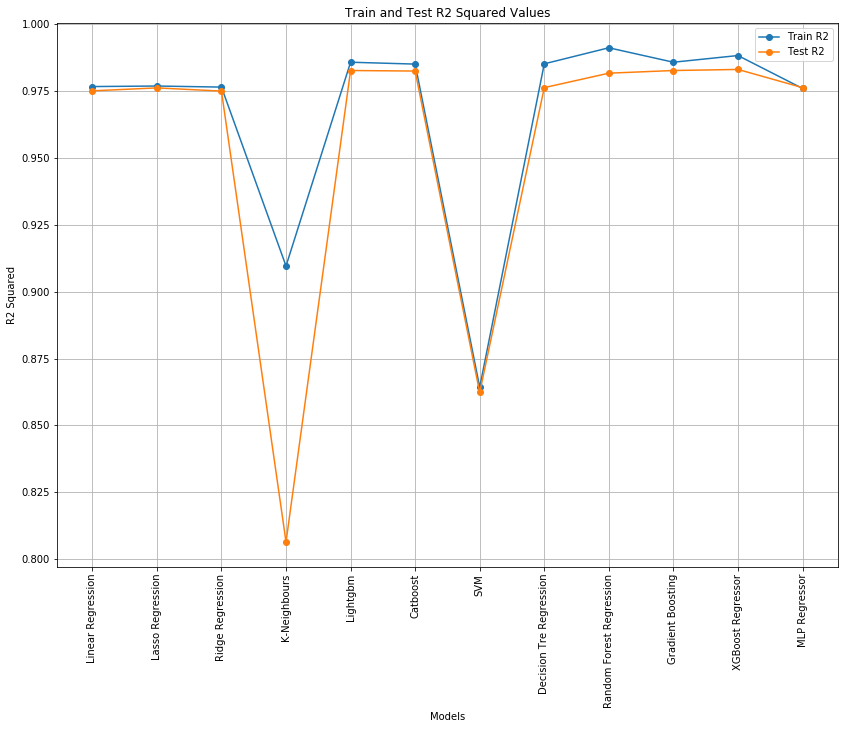

In [45]:
import matplotlib.pyplot as plt

# Filter train and test data
train_data = merged_df[merged_df['Set'] == 'Train']
test_data = merged_df[merged_df['Set'] == 'Test']

# Plotting
plt.figure(figsize=(14, 10))
plt.plot(train_data['index'], train_data['R2 Square'], marker='o', label='Train R2')
plt.plot(test_data['index'], test_data['R2 Square'], marker='o', label='Test R2')
plt.xlabel('Models')
plt.ylabel('R2 Squared')
plt.title('Train and Test R2 Squared Values')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show();


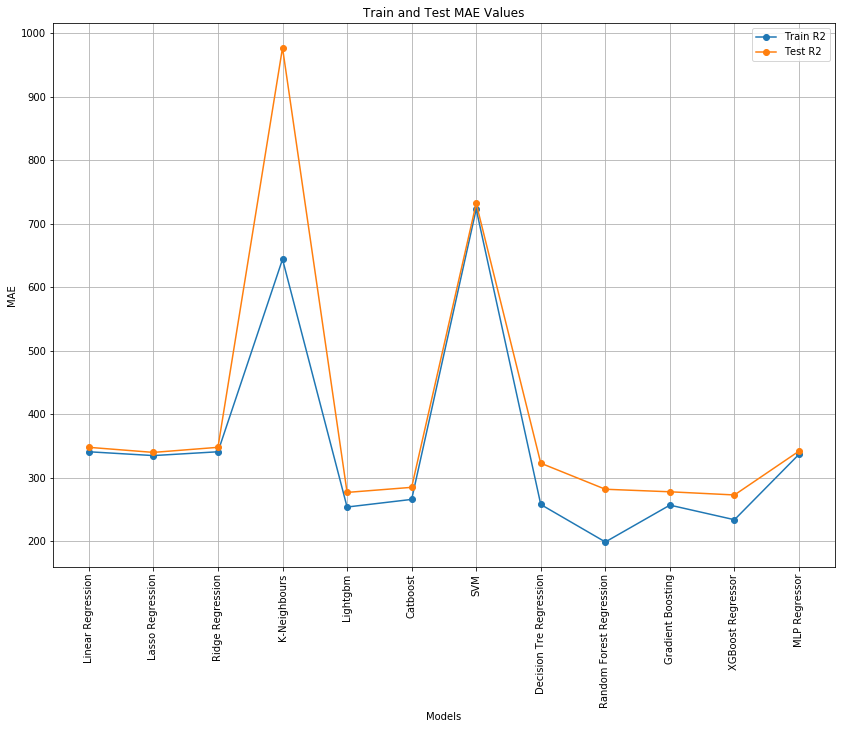

In [46]:
import matplotlib.pyplot as plt

# Filter train and test data
train_data = merged_df[merged_df['Set'] == 'Train']
test_data = merged_df[merged_df['Set'] == 'Test']

# Plotting
plt.figure(figsize=(14, 10))
plt.plot(train_data['index'], train_data['MAE'], marker='o', label='Train R2')
plt.plot(test_data['index'], test_data['MAE'], marker='o', label='Test R2')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('Train and Test MAE Values')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show();

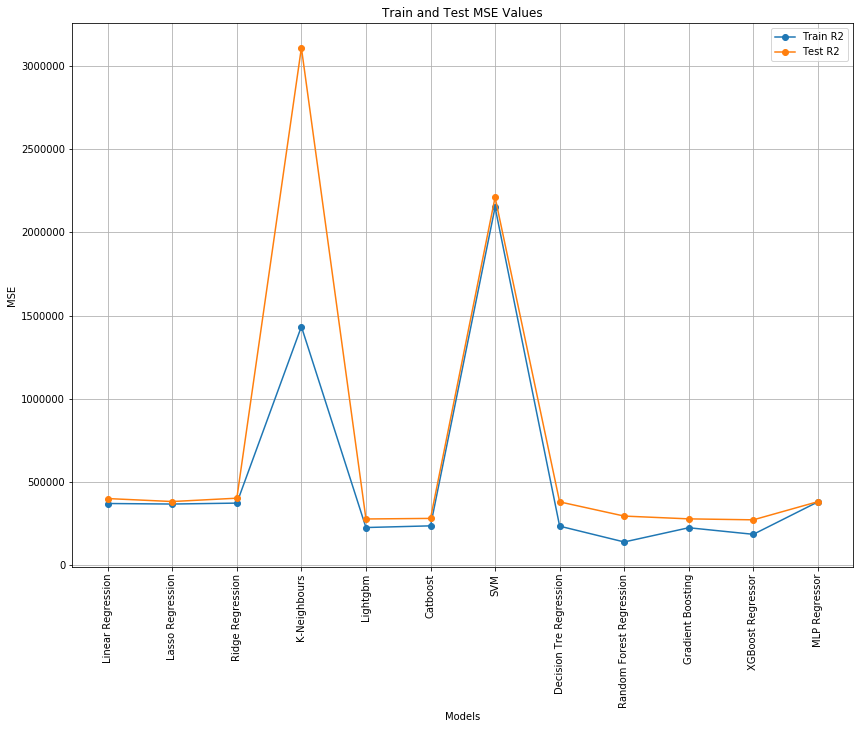

In [47]:
import matplotlib.pyplot as plt

# Filter train and test data
train_data = merged_df[merged_df['Set'] == 'Train']
test_data = merged_df[merged_df['Set'] == 'Test']

# Plotting
plt.figure(figsize=(14, 10))
plt.plot(train_data['index'], train_data['MSE'], marker='o', label='Train R2')
plt.plot(test_data['index'], test_data['MSE'], marker='o', label='Test R2')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Train and Test MSE Values')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show();

## Predicting on Sample Data

In [48]:
# Define the sample test data
sample_test_data = pd.DataFrame({
    'carat': [0.29, 0.24, 0.23, 0.3, 0.22],
    'cut': ['Premium', 'Very Good', 'Ideal', 'Good', 'Fair'],
    'color': ['I', 'J', 'J', 'J', 'E'],
    'clarity': ['VS2', 'VVS2', 'VS1', 'SI1', 'VS2'],
    'depth': [62.4, 62.8, 62.8, 63.8, 65.1],
    'table': [58, 57, 56, 56, 61],
})

# Encoding the categorical variables
sample_test_data['cut'] = sample_test_data['cut'].map({'Ideal': 4, 'Premium': 3, 'Very Good': 2, 'Good': 1, 'Fair': 0})
sample_test_data['color'] = sample_test_data['color'].map({'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0})
sample_test_data['clarity'] = sample_test_data['clarity'].map({'IF': 7, 'VVS1': 6, 'VVS2': 5, 'VS1': 4, 'VS2': 3, 'SI1': 2, 'SI2': 1, 'I1': 0})

# Making predictions using the LightGBM model
predictions_lgbm = best_lgbm.predict(sample_test_data)

# Adding predicted prices to the sample test data
sample_test_data['predicted_price'] = predictions_lgbm

# Displaying the sample test data with predicted prices
print(sample_test_data)

   carat  cut  color  clarity  depth  table  predicted_price
0   0.29    3      1        3   62.4     58       434.284811
1   0.24    2      0        5   62.8     57       318.264388
2   0.23    4      0        4   62.8     56       304.143828
3   0.30    1      0        2   63.8     56       381.084053
4   0.22    0      5        3   65.1     61       374.947508


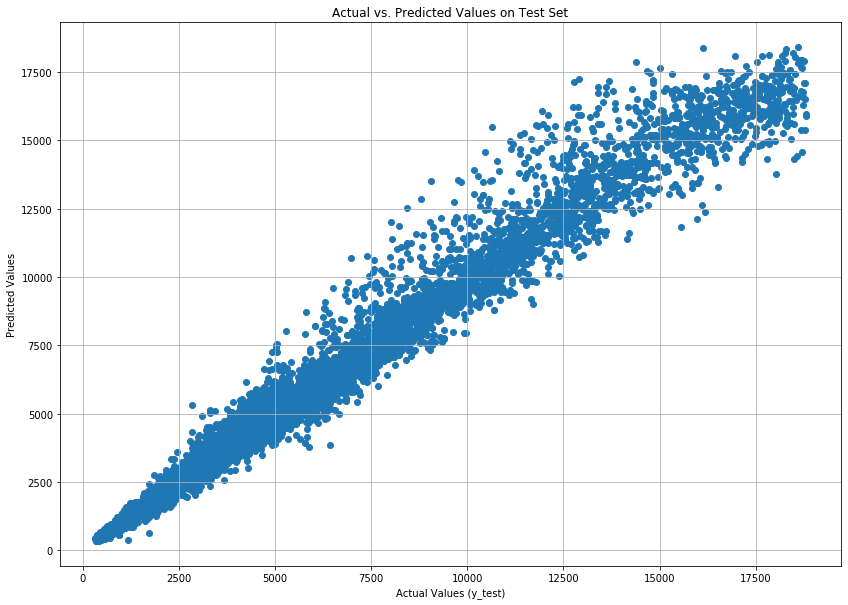

In [49]:
# Plotting
plt.figure(figsize=(14, 10))
plt.scatter(y_test, best_lgbm.predict(X_test))
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values on Test Set')
plt.grid(True)
plt.show();


## Feature Importance

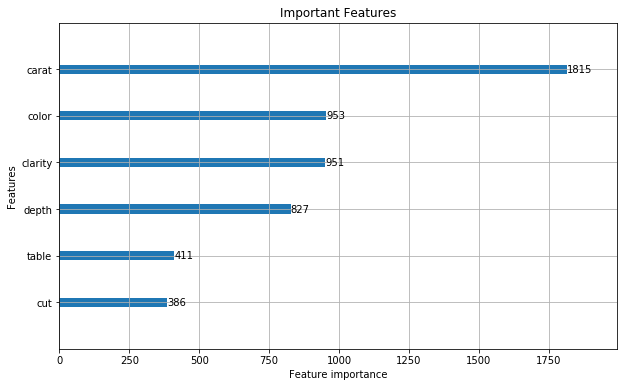

In [50]:
lgb.plot_importance(best_lgbm, figsize=(10,6))
plt.title("Important Features")
plt.show();